### Sample size effect in gene co-expression networks (with networkx)

- Author: Joaquim Aguirre Plans<br>
- Institution: Northeastern University

Load libraries:

In [1]:
import sys, os
import graph_tool.all as gt
import matplotlib.pyplot as plt
import multiprocessing as mp
import networkx as nx
import numpy as np
import pandas as pd
import pylab
import random
import seaborn as sns
import scipy
import time
import NetworkMedicineToolbox.wrappers as wrappers
import NetworkMedicineToolbox.network_utilities as network_utilities
import NetworkMedicineToolbox.parse_ncbi as parse_ncbi
import NetworkMedicineToolbox.parse_mesh as parse_mesh
import coexpression_analysis_functions_networkx as canx
random.seed(1510)

/home/j.aguirreplans/.conda/envs/ScipherSampleSizeEnv/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:1494: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!
DIAMOnD not found and thus will not be available!


In [4]:
print(pd.__version__)

1.2.4


## Sample size effect in network size and composition

In this part, I check the effect of the sample size in the size of gene co-expression networks.

In [2]:
# Define directories and files
scratch_data_dir = '/scratch/j.aguirreplans/Scipher/SampleSize'
home_data_dir = '/home/j.aguirreplans/Projects/Scipher/SampleSize/data'
databases_dir = '/home/j.aguirreplans/Databases'
ppi_dir = '/home/j.aguirreplans/data/PPI'
#wto_results_dir = os.path.join(scratch_data_dir, 'networks_nonresponders_wto_N100')
wto_results_dir = os.path.join(scratch_data_dir, 'example_networks_nonresponders_wto')
output_dir = os.path.join(home_data_dir, 'out')
#plots_dir = os.path.join(output_dir, 'plots')
plots_dir = os.path.join(output_dir, 'plots_example')


In [3]:
# Parse all genes from gene expression data
gene_expression_file = '/home/j.aguirreplans/Projects/Scipher/SampleSize/data/bootstrap/nonresponders/RNAseq_NonResponders_all.txt'
gene_expression_df = pd.read_csv(gene_expression_file, sep='\t')
genes_dataset = gene_expression_df.columns[1:]
print(len(genes_dataset))


15192


In [4]:
# Define parameters of bootstrap
rep = 10
step = 10
max_num_samples = 56
pval_adj_cutoff = 0.01
size_list = list(range(10, max_num_samples+1, step))
print('List of sample sizes considered: {}'.format(', '.join([str(size) for size in size_list])))
print('Number of repetitions of each sample size: {}'.format(rep))
top_percent = 0.1
top_scoring = None
if top_percent:
    num_nodes = len(genes_dataset)
    total_number_of_edges = float(num_nodes*(num_nodes-1))/2.0
    top_scoring = round(total_number_of_edges*float(top_percent)/100.0)
    print('Percentage of edges selected: {}% of {}. Number of edges selected: {}'.format(top_percent, int(total_number_of_edges), top_scoring))


List of sample sizes considered: 10, 20, 30, 40, 50
Number of repetitions of each sample size: 10
Percentage of edges selected: 0.1% of 115390836. Number of edges selected: 115391


In [5]:
# Parse global network (using NX)
global_network_file = os.path.join(wto_results_dir, 'wto_RNAseq_NonResponders_all.net')

start = time.time() # Starting time
#global_sig_network = canx.parse_significant_coexpression_network_from_wto_reading_the_file(global_network_file, pval_adj_cutoff=pval_adj_cutoff)
global_sig_network = canx.parse_significant_coexpression_network_from_wto_with_pandas(global_network_file, pval_adj_cutoff=pval_adj_cutoff, top_scoring=top_scoring)
end = time.time() # End time
print("Runtime for loading the network is {}".format(end-start))

print('Global gene co-expression network: {} nodes and {} edges'.format(len(global_sig_network.nodes()), len(global_sig_network.edges())))
global_sig_network_nodes = set(global_sig_network.nodes())
global_sig_network_edges = set(global_sig_network.edges())


Runtime for loading the network is 0.027332305908203125
Global gene co-expression network: 99 nodes and 1725 edges


In [ ]:
Gbig = nx.Graph()
Gsmall = nx.Graph()
Gbig.add_edges([('a', 'b'),('a','c'),('b','d'),('c','d'),('d','e')])
Gsmall.add_edges([('a', 'b'),('a','d'),('b','d'),('c','d')])
lost_nodes, gained_nodes, lost_edges, gained_edges = canx.calculate_difference_between_networks(global_sig_network_nodes, global_sig_network_edges, subsample_sig_network_nodes, subsample_sig_network_edges)


In [7]:
# Parse PPI network
#ppi_network_file = os.path.join(ppi_dir, 'interactome_2019_merged.csv')
#ppi_info_file = os.path.join(ppi_dir, 'interactome_2019_merged_protAnnots.csv')
#ppi_info = pd.read_csv(ppi_info_file, index_col=0, header=0) # Read PPI info
#ppi = parse_ppi_network(ppi_network_file)
#print('PPI network: {} nodes and {} edges'.format(len(ppi.nodes()), len(ppi.edges())))
#ppi = parse_ppi_network_with_graphtools(ppi_network_file)
#print('PPI network: {} nodes and {} edges'.format(len(ppi.get_vertices()), len(ppi.get_edges())))


In [8]:
# Parse NCBI gene to get a dictionary gene ID to gene symbol
ncbi_gene_info_file = os.path.join(home_data_dir, 'Homo_sapiens.gene_info')
geneid_to_genesymbol, genesymbol_to_geneid = parse_ncbi.get_geneid_symbol_mapping(ncbi_gene_info_file)


In [9]:
# Parse MeSH to get the class of each disease (the root concepts in MeSH)
mesh_file = os.path.join(databases_dir, 'MeSH/mtrees2021.bin')
m = parse_mesh.MESH(mesh_file)
g = m.get_ontology(lower_concepts=True)


In [10]:
# Parse disease genes associated to diseases with 20 genes or more
# Map the disease to its corresponding class
disease_genes_file = '/home/j.aguirreplans/Projects/Scipher/SampleSize/data/Guney2016_GenesDisease.tsv'
disease2genes = {}
disease2genesdataset = {}
disease2types = {}
for i in open(disease_genes_file).readlines():
    v = i.rstrip().split('\t')
    disease = v[1]
    genes = v[2:]
    if len(genes) > 19:
        if disease in m.concept_to_concept_ids:
            disease2genes[disease] = [geneid_to_genesymbol[i] for i in genes if str(i) in geneid_to_genesymbol]
            disease2genesdataset[disease] = [gene for gene in disease2genes[disease] if gene in genes_dataset]
            concept_ids = m.concept_to_concept_ids[disease]
            for concept_id in concept_ids:
                root_concept_id = concept_id.split('.')[0]
                root_concept = m.concept_id_to_concept[root_concept_id]
                disease2types.setdefault(disease, set()).add(root_concept)
                #print(concept_id, disease, root_concept_id, root_concept)


In [11]:
diseasegenes = list(disease2genes.values())
diseasegenes = sum(diseasegenes, [])
diseasegenes = set(diseasegenes)
print(len(diseasegenes))
diseasegenesdataset = list(disease2genesdataset.values())
diseasegenesdataset = sum(diseasegenesdataset, [])
diseasegenesdataset = set(diseasegenesdataset)
print(len(diseasegenesdataset))


3161
1938


In [ ]:
# Parse RA genes (from RA analysis) and compare it with the list of genes from Guney et al.
ra_file = os.path.join(home_data_dir, 'RA_Genes.txt')
RA_genes = list(pd.read_csv(ra_file, sep=' ', header=None).iloc[:, 0])
RA_genes_network = [gene for gene in RA_genes if gene in global_sig_network_nodes]
print('RA (initial list): {} genes, {} genes in gene co-expression network'.format(len(RA_genes), len(RA_genes_network)))
#print(RA_genes_network)
RA_new_genes = disease2genes['arthritis, rheumatoid']
RA_new_genes_network = [gene for gene in disease2genes['arthritis, rheumatoid'] if gene in global_sig_network_nodes]
print('RA (new list): {} genes, {} genes in gene co-expression network'.format(len(RA_new_genes), len(RA_new_genes_network)))


In [16]:
# Parse subsample networks
topology_df = pd.DataFrame(columns=['size', 'rep', 'nodes', 'edges', 'av_degree', 'av_path_length', 'av_clustering_coef', 'num_communities'])
composition_df = pd.DataFrame(columns=['size', 'rep', 'nodes', 'edges', 'lost_or_gained'])
kendall_df = pd.DataFrame(columns=['size', 'kendall'])
components_df = pd.DataFrame(columns=['size', 'rep', 'num_components', 'size_lcc'])
disease_df = pd.DataFrame(columns=['size', 'rep', 'disease', 'disease_class', 'total_disease_genes', 'total_disease_genes_in_dataset', 'disease_genes_in_network', 'lcc_size'])
for size in size_list:
    #wto_list_of_same_sample_size = []
    for r in range(1, rep+1):
        subsample_network_file = os.path.join(wto_results_dir, 'wto_RNAseq_NonResponders_sample_{}_rep_{}.net'.format(size, r))
        if canx.fileExist(subsample_network_file):

            # Parse subsample network
            start = time.time() # Starting time
            #subsample_network = parse_coexpression_network_from_wto(subsample_network_file)
            #subsample_sig_network = canx.parse_significant_coexpression_network_from_wto_reading_the_file(subsample_network_file, pval_adj_cutoff=pval_adj_cutoff)
            subsample_sig_network = canx.parse_significant_coexpression_network_from_wto_with_pandas(subsample_network_file, pval_adj_cutoff=pval_adj_cutoff, top_scoring=top_scoring)
            print('THE NETWORK HAS {} EDGES AND {} NODES'.format(len(subsample_sig_network.edges()), len(subsample_sig_network.nodes())))
            end = time.time() # End time
            print("Runtime for loading the network in sample size {} and rep {} is {}".format(size, r, end-start))

            # Get weights & ranks associated to weights
            #wto_weights = [subsample_network[u][v]['wto'] for u,v in global_network.edges()]
            #wto_ranks = scipy.stats.rankdata(wto_weights)
            #wto_list_of_same_sample_size.append(wto_ranks)
            
            # Get components and LCC
            start = time.time() # Starting time
            subsample_sig_components = network_utilities.get_connected_components(G=subsample_sig_network, return_as_graph_list=True)
            av_path_length_components = []
            for component in subsample_sig_components:
                # Calculate the average path length of each component (it cannot be calculated in a disconnected graph)
                av_path_length_components.append(nx.average_shortest_path_length(component))
            subsample_sig_lcc = subsample_sig_network.subgraph(subsample_sig_components[0])
            df2 = pd.DataFrame([[size, r, len(subsample_sig_components), len(subsample_sig_lcc.nodes())]], columns=['size', 'rep', 'num_components', 'size_lcc'])
            components_df = components_df.append(df2)
            subsample_sig_components = []
            subsample_sig_lcc = []
            end = time.time() # End time
            print("Runtime for calculating the components in sample size {} and rep {} is {}".format(size, r, end-start))

            # Get topological measures
            av_degree = 2*float(len(subsample_sig_network.edges()))/float(len(subsample_sig_network.nodes()))
            av_path_length = np.mean(av_path_length_components)
            av_clustering_coef = nx.average_clustering(subsample_sig_network)
            # Community detection algorithm info:
            # https://memgraph.com/blog/community_detection-algorithms_with_python_networkx
            # https://orbifold.net/default/community-detection-using-networkx/
            communities = nx.algorithms.community.centrality.girvan_newman(subsample_sig_network)
            node_groups = []
            for com in communities:
              node_groups.append(list(com))
            df2 = pd.DataFrame([[size, r, len(subsample_sig_network.nodes()), len(subsample_sig_network.edges()), av_degree, av_path_length, av_clustering_coef, len(node_groups)]], columns=['size', 'rep', 'nodes', 'edges', 'av_degree', 'av_path_length', 'av_clustering_coef', 'num_communities'])
            topology_df = topology_df.append(df2)
            av_path_length_components = []
            communities = []
            node_groups = []

            # Get connected disease genes
            start = time.time() # Starting time
            for disease in disease2genes.keys():
                disease_genes = disease2genes[disease]
                disease_genes_dataset = disease2genesdataset[disease]
                disease_subgraph = subsample_sig_network.subgraph(disease_genes)
                disease_components = network_utilities.get_connected_components(G=disease_subgraph, return_as_graph_list=False)
                if len(disease_components) > 0:
                    disease_lcc = disease_subgraph.subgraph(disease_components[0])
                    disease_lcc_nodes = disease_lcc.nodes()
                else:
                    disease_lcc = []
                    disease_lcc_nodes = []
                for disease_class in disease2types[disease]:
                    df2 = pd.DataFrame([[size, r, disease, disease_class, len(disease_genes), len(disease_genes_dataset), len(disease_subgraph.nodes()), len(disease_lcc_nodes)]], columns=['size', 'rep', 'disease', 'disease_class', 'disease_genes', 'disease_genes_in_dataset', 'disease_genes_in_network', 'lcc_size'])
                    disease_df = disease_df.append(df2)
                disease_subgraph = []
                disease_components = []
                disease_lcc = []
            end = time.time() # End time
            print("Runtime for calculating the module properties of each disease in sample size {} and rep {} is {}".format(size, r, end-start))

            # Calculate differences between global and subsample network
            start = time.time() # Starting time
            subsample_sig_network_edges = set(subsample_sig_network.edges())
            end = time.time() # End time
            print("Runtime for calculating the set of edges in sample size {} and rep {} is {}".format(size, r, end-start))
            start = time.time() # Starting time
            subsample_sig_network_nodes = set(subsample_sig_network.nodes())
            end = time.time() # End time
            print("Runtime for calculating the set of nodes in sample size {} and rep {} is {}".format(size, r, end-start))
            start = time.time() # Starting time
            lost_nodes, gained_nodes, lost_edges, gained_edges = canx.calculate_difference_between_networks(global_sig_network_nodes, global_sig_network_edges, subsample_sig_network_nodes, subsample_sig_network_edges)
            #print(size, r, len(lost_edges), len(gained_edges))
            df3 = pd.DataFrame([[size, r, len(lost_nodes), len(lost_edges), 'lost']], columns=['size', 'rep', 'nodes', 'edges', 'lost_or_gained'])
            composition_df = composition_df.append(df3)
            #lost_nodes, gained_nodes, lost_edges, gained_edges = cagt.calculate_difference_between_networks_with_graphtools(global_sig_network, subsample_sig_network)
            #df3 = pd.DataFrame([[size, r, len(lost_nodes), len(lost_edges), 'lost']], columns=['size', 'rep', 'nodes', 'edges', 'lost_or_gained'])
            #composition_df = composition_df.append(df3)
            df4 = pd.DataFrame([[size, r, len(gained_nodes), len(gained_edges), 'gained']], columns=['size', 'rep', 'nodes', 'edges', 'lost_or_gained'])
            composition_df = composition_df.append(df4)
            subsample_sig_network_edges = []
            subsample_sig_network_nodes = []
            lost_nodes = []
            lost_edges = []
            gained_nodes = []
            gained_edges = []
            end = time.time() # End time
            print("Runtime for calculating the composition in sample size {} and rep {} is {}".format(size, r, end-start))

        else:
            print('Missing file: {}'.format(subsample_network_file))
        #break
    #W, count = calculate_kendall(np.array(wto_list_of_same_sample_size), n_permutations=1000)
    #df5 = pd.DataFrame([[size, W]], columns=['size', 'kendall'])
    #kendall_df = kendall_df.append(df5)
    #break
#print(topology_df)
#print(composition_df)
#print(components_df)
#print(RA_df)


THE NETWORK HAS 212 EDGES AND 60 NODES
Runtime for loading the network in sample size 10 and rep 1 is 0.011205196380615234
Runtime for calculating the components in sample size 10 and rep 1 is 0.013218879699707031
Runtime for calculating the module properties of each disease in sample size 10 and rep 1 is 1.392430067062378
Runtime for calculating the set of edges in sample size 10 and rep 1 is 0.00010919570922851562
Runtime for calculating the set of nodes in sample size 10 and rep 1 is 9.5367431640625e-06
Runtime for calculating the composition in sample size 10 and rep 1 is 0.0033490657806396484
THE NETWORK HAS 186 EDGES AND 62 NODES
Runtime for loading the network in sample size 10 and rep 2 is 0.00781559944152832
Runtime for calculating the components in sample size 10 and rep 2 is 0.007662534713745117
Runtime for calculating the module properties of each disease in sample size 10 and rep 2 is 1.4796390533447266
Runtime for calculating the set of edges in sample size 10 and rep 2 i

### Sample size effect on network size

I plot the number of nodes and edges of the different networks with respect to the sample size.

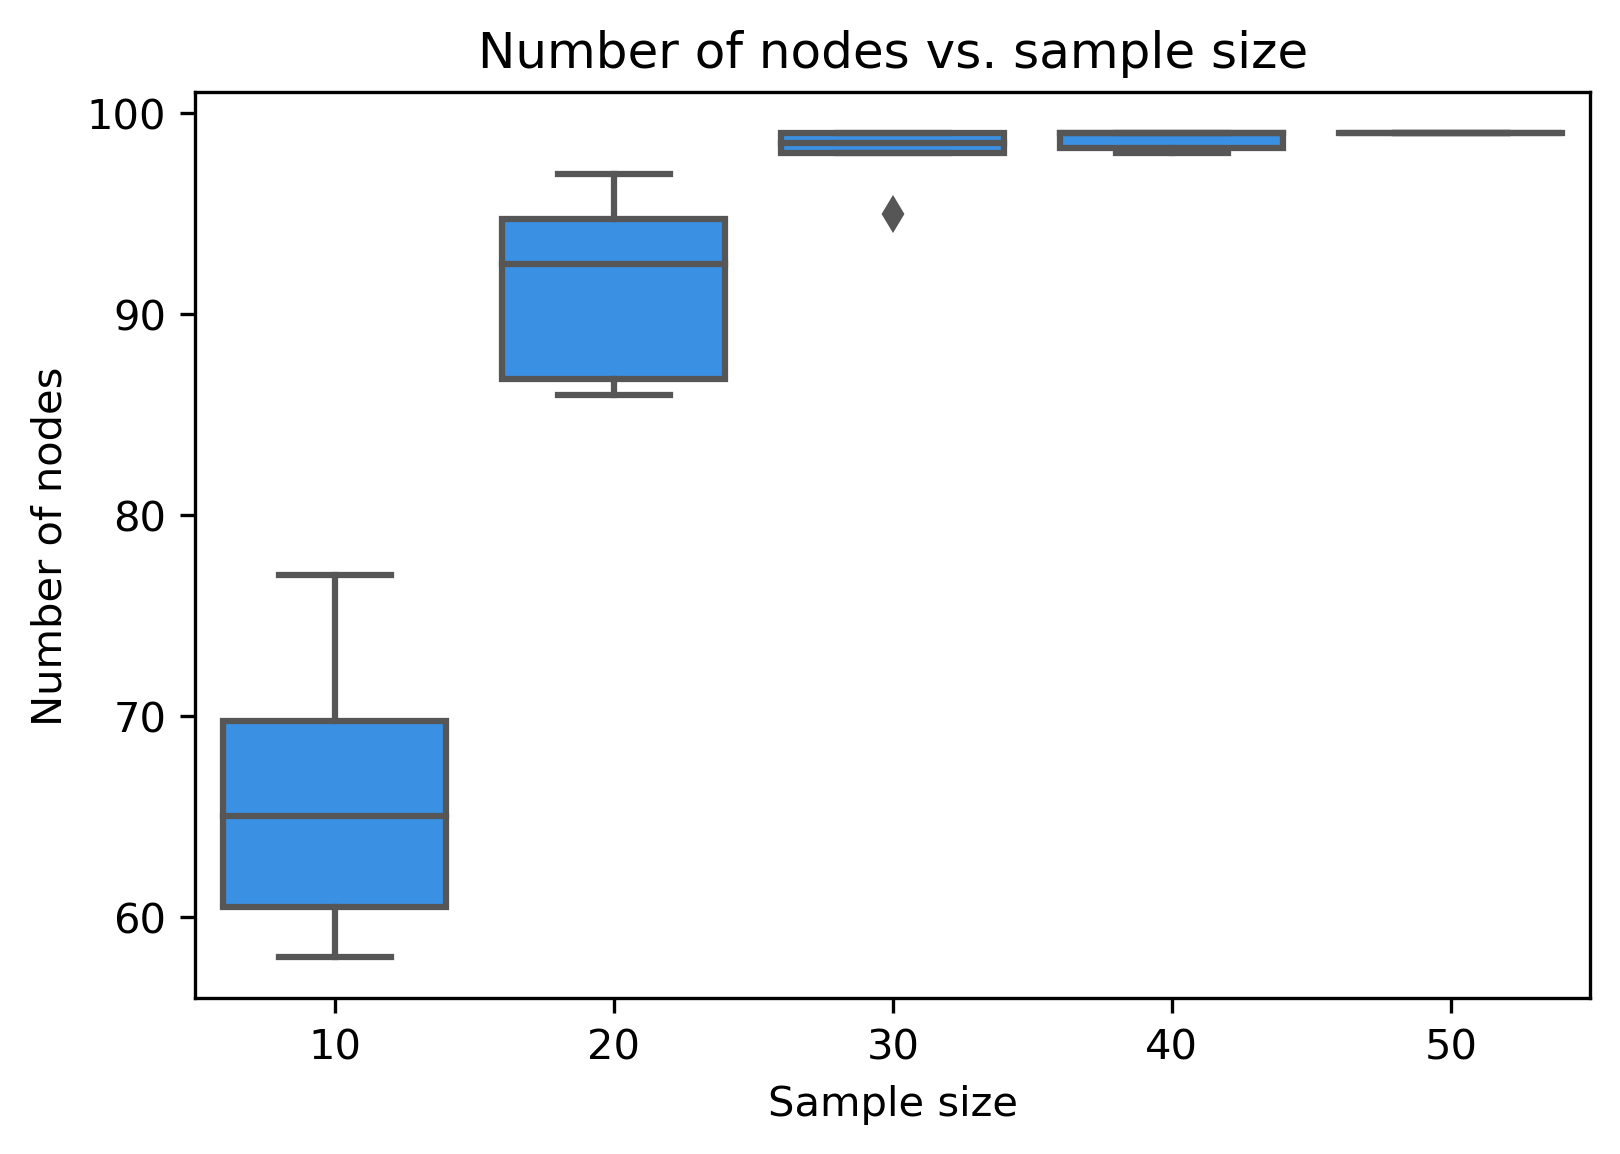

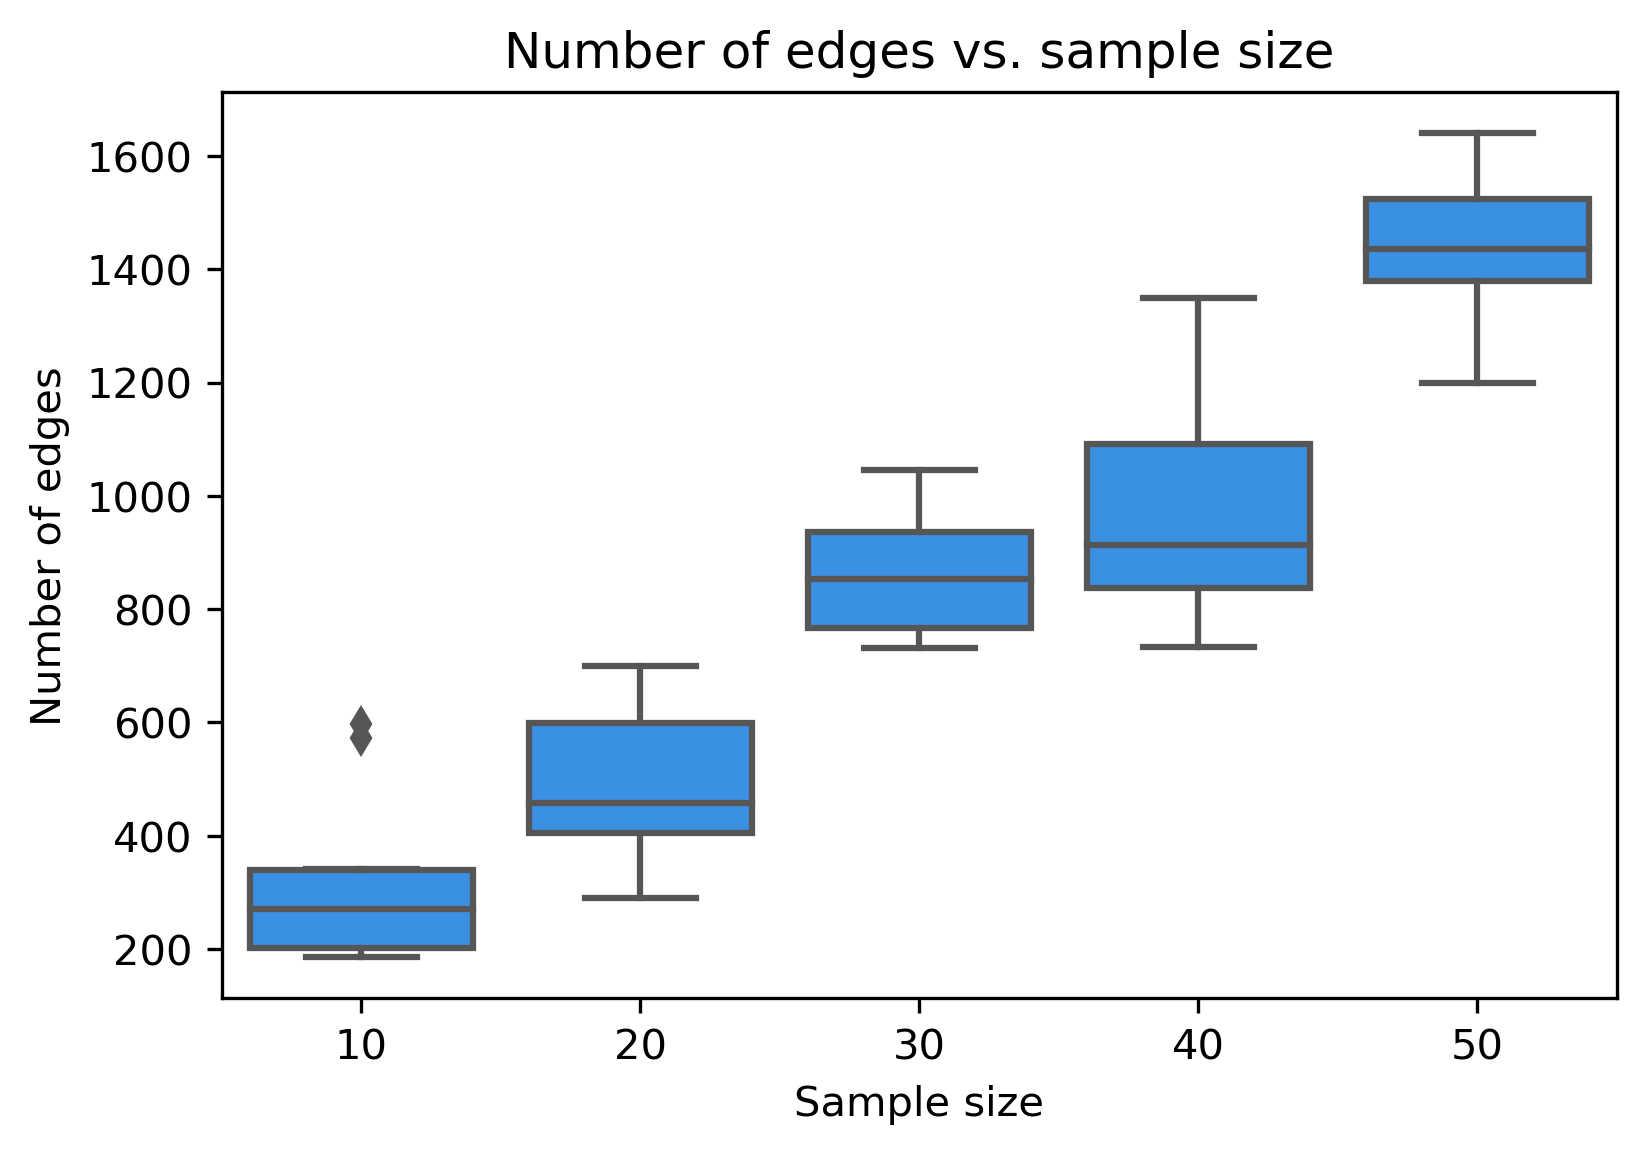

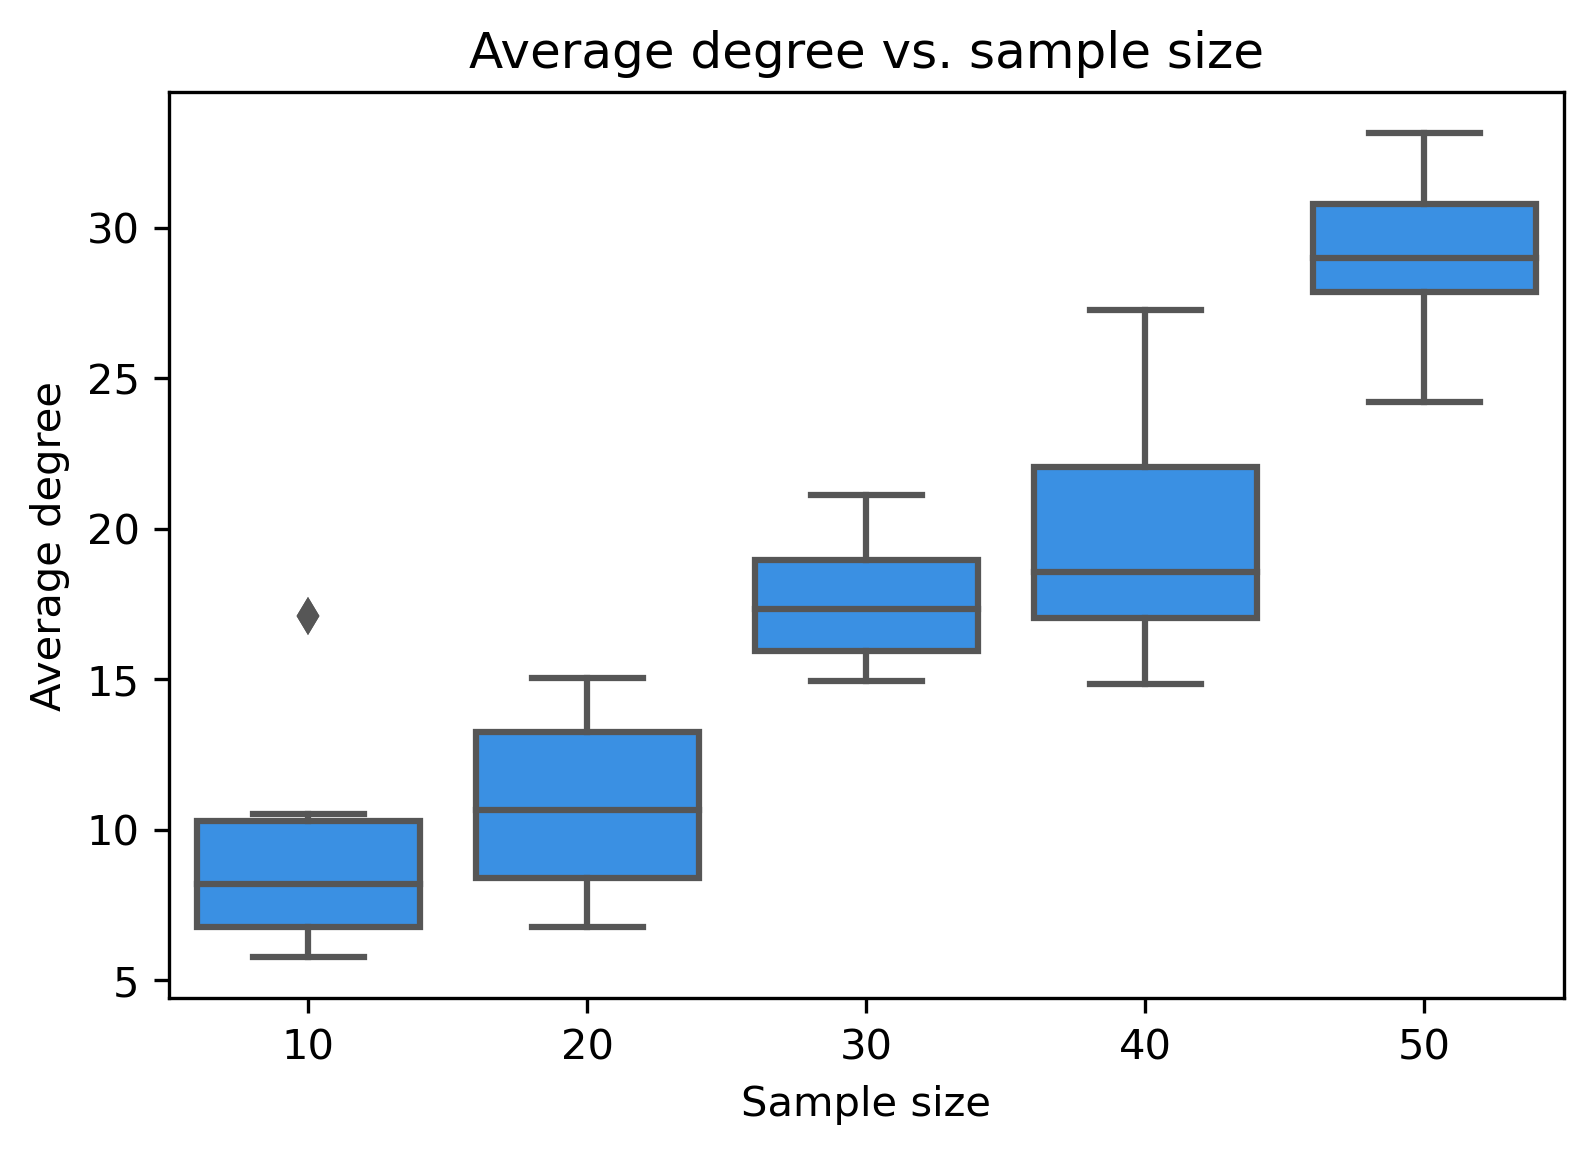

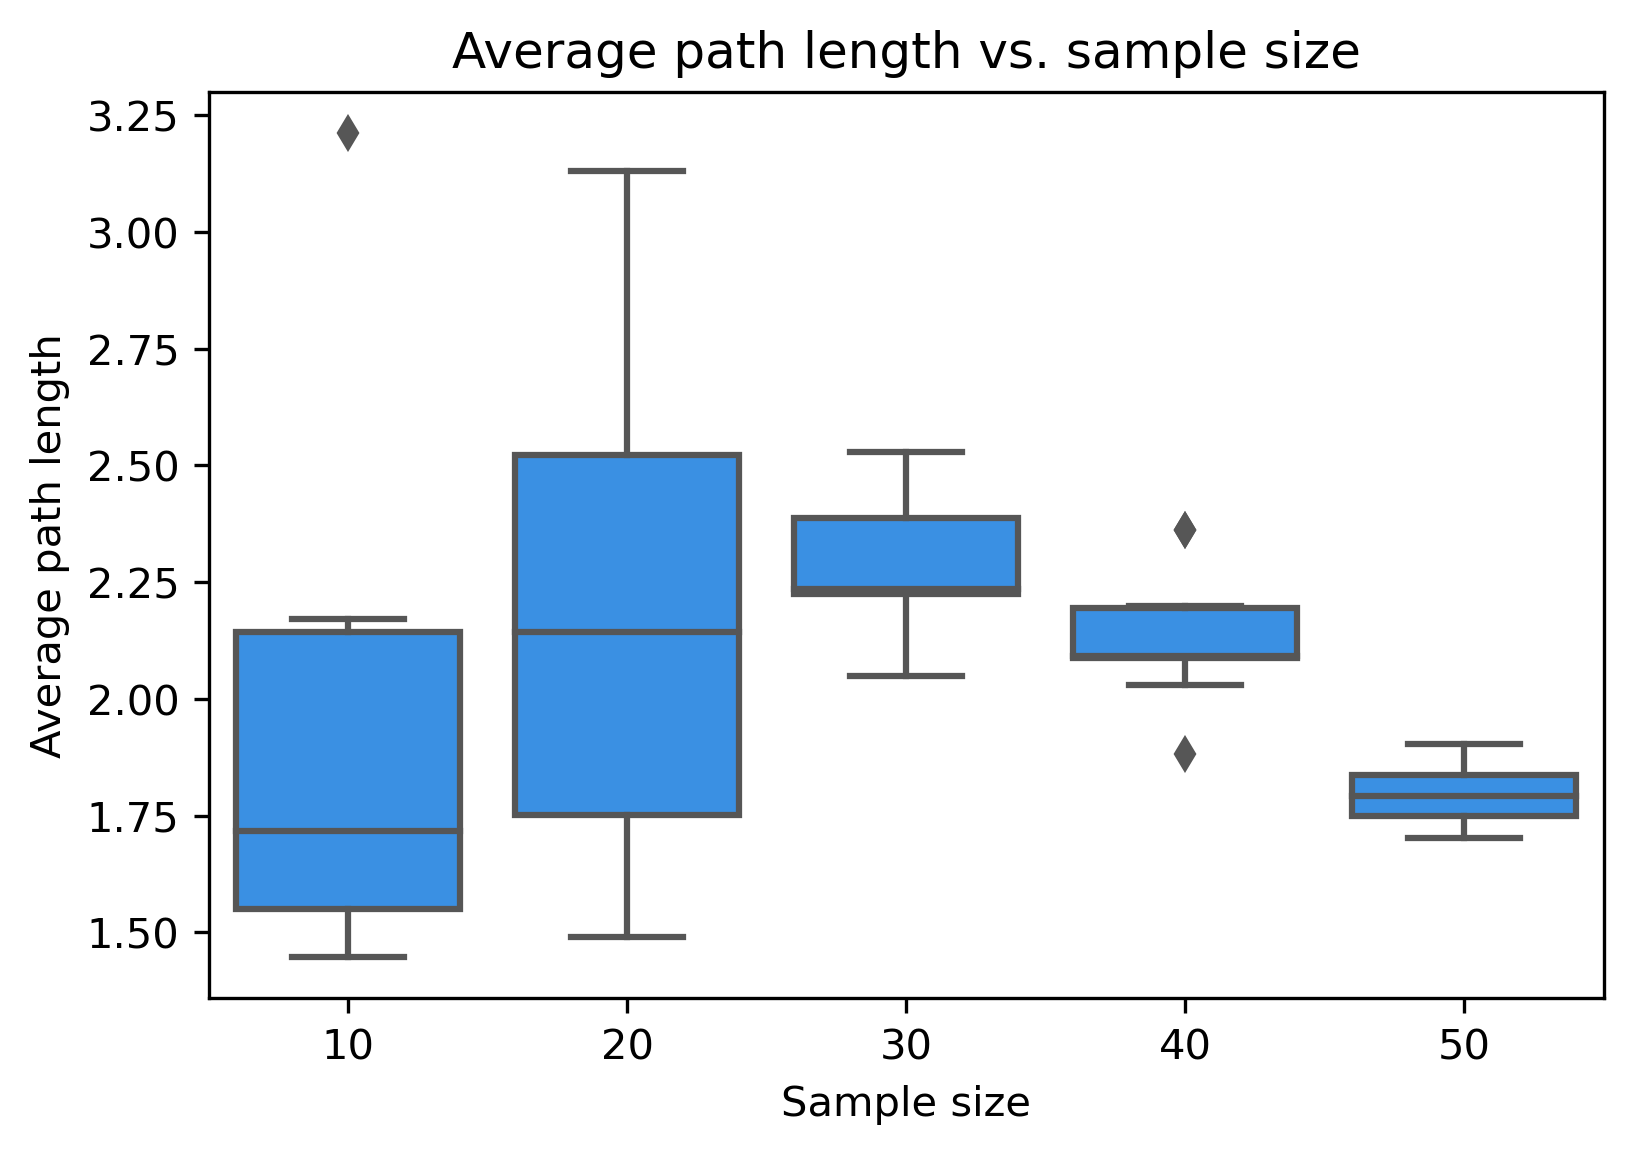

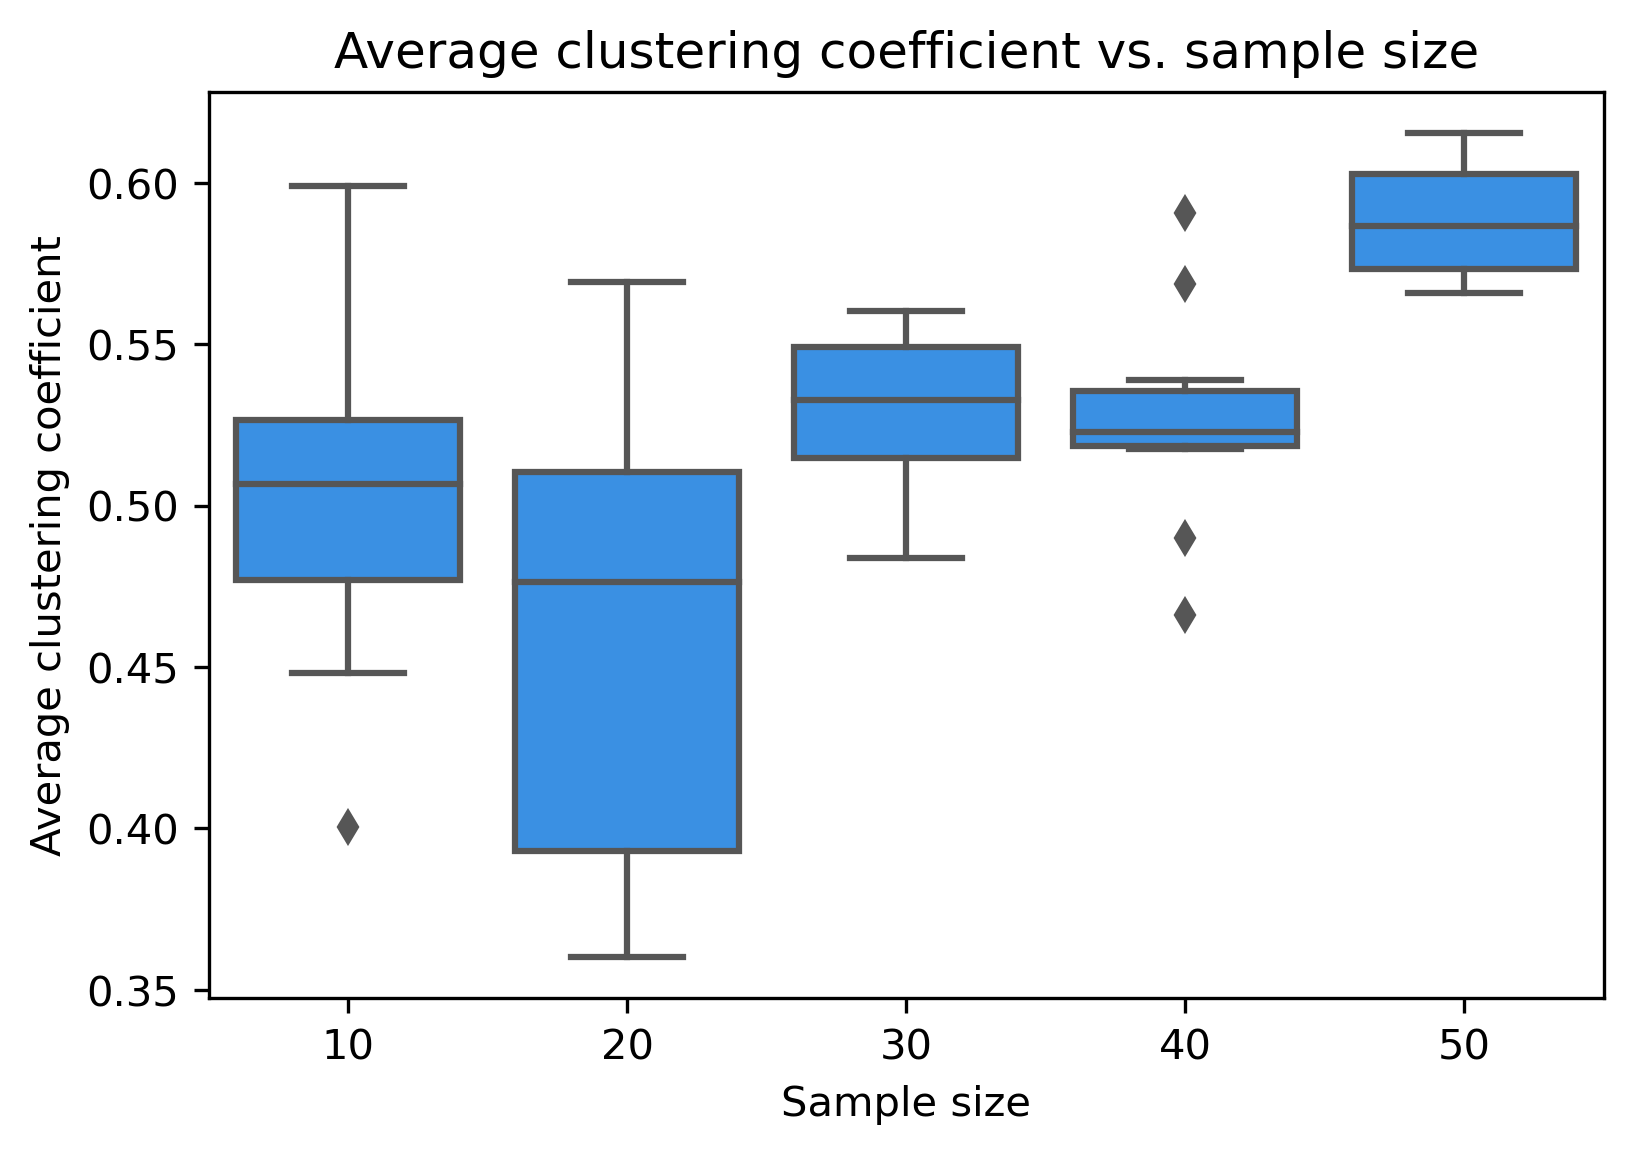

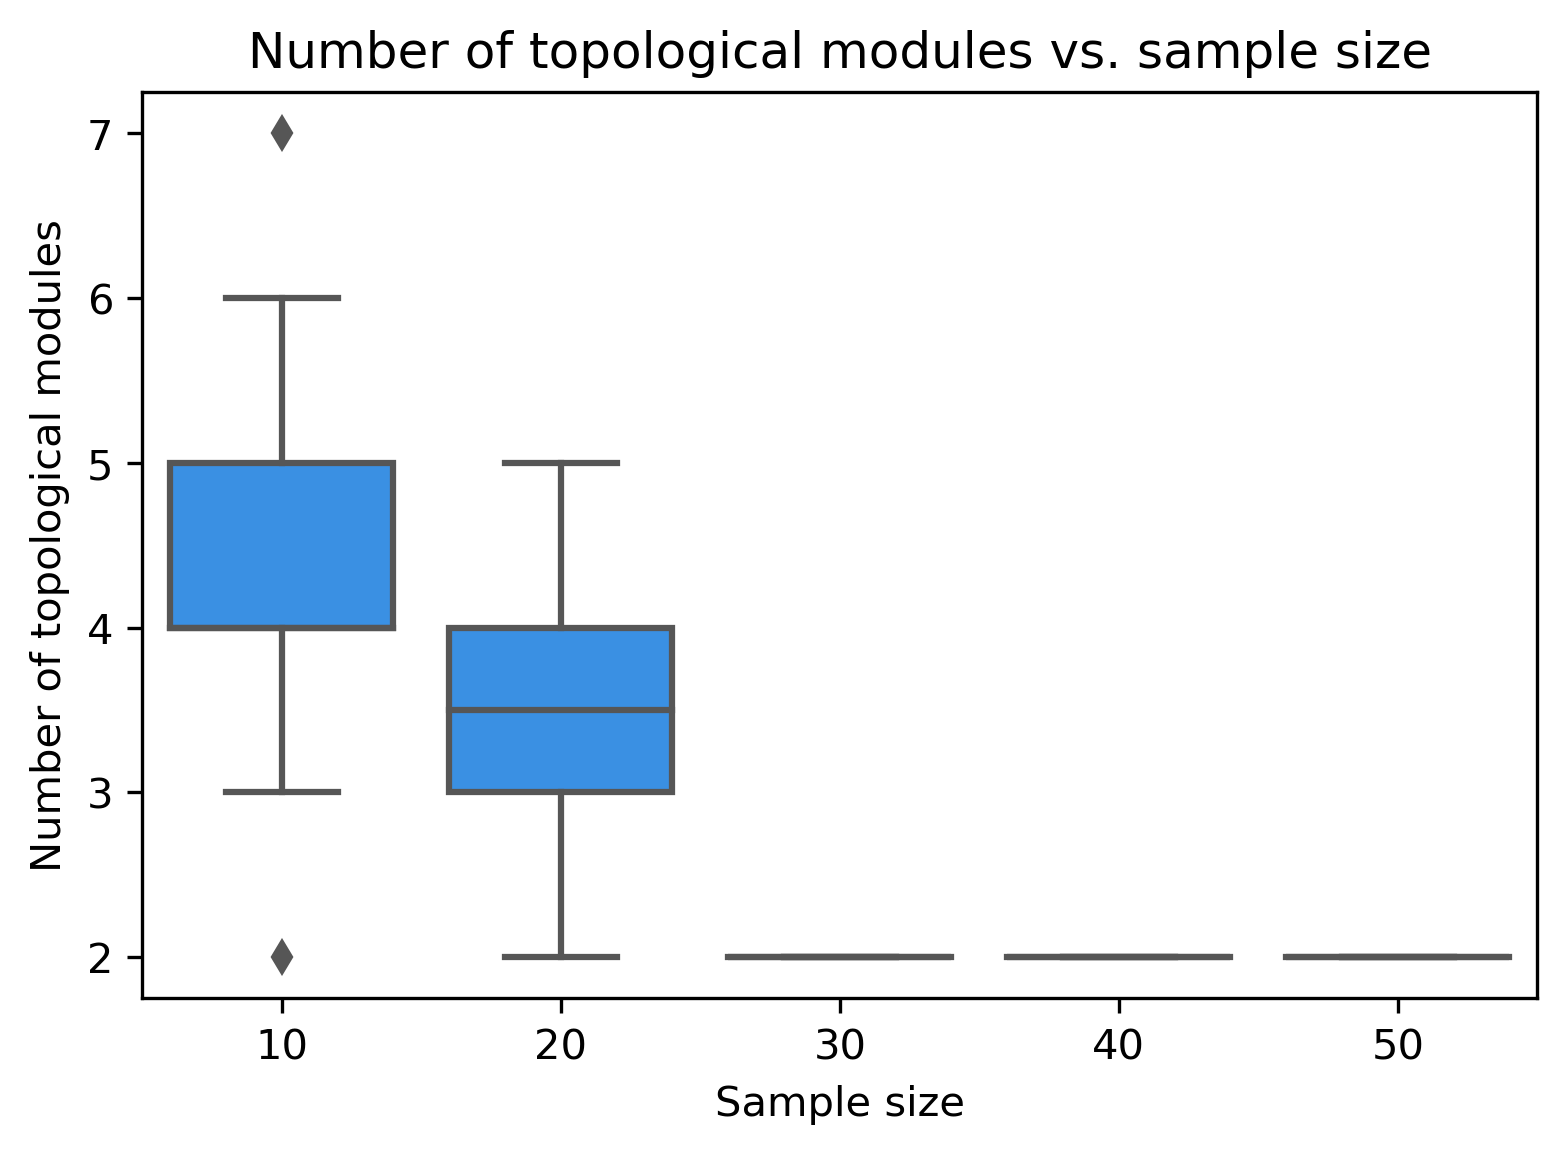

In [15]:
# Plot num. of nodes vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_df, x='size', y='nodes', color='dodgerblue')
plt.title('Number of nodes vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Number of nodes')
pylab.savefig(os.path.join(plots_dir, 'num_nodes_vs_sample_size.png'), format='png')
plt.show()

# Plot num. of edges vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_df, x='size', y='edges', color='dodgerblue')
plt.title('Number of edges vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Number of edges')
pylab.savefig(os.path.join(plots_dir, 'num_edges_vs_sample_size.png'), format='png')
plt.show()

# Plot average degree vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_df, x='size', y='av_degree', color='dodgerblue')
plt.title('Average degree vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Average degree')
pylab.savefig(os.path.join(plots_dir, 'av_degree_vs_sample_size.png'), format='png')
plt.show()

# Plot average path length vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_df, x='size', y='av_path_length', color='dodgerblue')
plt.title('Average path length vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Average path length')
pylab.savefig(os.path.join(plots_dir, 'av_path_length_vs_sample_size.png'), format='png')
plt.show()

# Plot average clustering coefficient vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_df, x='size', y='av_clustering_coef', color='dodgerblue')
plt.title('Average clustering coefficient vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Average clustering coefficient')
pylab.savefig(os.path.join(plots_dir, 'av_clustering_coef_vs_sample_size.png'), format='png')
plt.show()

# Plot number of topological communities vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=topology_df, x='size', y='num_communities', color='dodgerblue')
plt.title('Number of topological modules vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Number of topological modules')
pylab.savefig(os.path.join(plots_dir, 'topological_modules_vs_sample_size.png'), format='png')
plt.show()

### Sample size effect in network composition

Here, I check the impact of sample size in the composition of nodes and edges of gene co-expression networks. With this purpose, I check the number of lost and gained edges with respect to the network that has the 100% of samples.

In [ ]:
# Plot num. of nodes lost and gained vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=composition_df, x="size", y="nodes", hue="lost_or_gained", palette=["dodgerblue", "gold"])
plt.title('Number of lost and gained nodes vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Number of nodes')
pylab.savefig(os.path.join(plots_dir, 'num_lost_nodes_vs_sample_size.png'), format='png')
plt.show()

# Plot num. of edges lost and gained vs sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=composition_df, x="size", y="edges", hue="lost_or_gained", palette=["dodgerblue", "gold"])
plt.title('Number of lost and gained edges vs. sample size')
plt.xlabel('Sample size')
plt.ylabel('Number of edges')
pylab.savefig(os.path.join(plots_dir, 'num_lost_edges_vs_sample_size.png'), format='png')
plt.show()

### Sample size effect on the number of components and size of the LCC

In [ ]:
# Plot num. of components vs. sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=components_df, x='size', y='num_components', color='dodgerblue')
plt.title('Number of connected components in the gene co-expression network')
plt.xlabel('Sample size')
plt.ylabel('Number of connected components')
pylab.savefig(os.path.join(plots_dir, 'num_connected_components_vs_sample_size.png'), format='png')
plt.show()


In [ ]:
# Plot num. of components vs. sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=components_df, x='size', y='size_lcc', color='dodgerblue')
plt.title('Size of the LCC in the gene co-expression network')
plt.xlabel('Sample size')
plt.ylabel('Number of nodes in the LCC')
pylab.savefig(os.path.join(plots_dir, 'LCC_size_vs_sample_size.png'), format='png')
plt.show()


## Sample size effect on reproducibility of the network

In [ ]:
#fig = pylab.figure(dpi=300)
#sns.lineplot(data=kendall_df, x="size", y="kendall", marker="o")
#plt.title('Kendall\'s W vs. sample size')
#plt.xlabel('Sample size')
#plt.ylabel('Kendall\'s W')
#pylab.savefig(os.path.join(plots_dir, 'kendall_vs_sample_size.png'), format='png')
#plt.show()

## Sample size effect on different disease modules

In [ ]:
disease_df
print(disease_df[disease_df["disease_genes_in_dataset"] > 0])


In [ ]:
print(len(set(disease_df["disease_class"])))

In [ ]:
disease_class_count = disease_df[["disease", "disease_class"]].drop_duplicates().groupby('disease_class').count()
disease_class_count


In [ ]:
print(sum(disease_class_count["disease"]))
sns.histplot(data=disease_class_count, x='disease', color='dodgerblue')


In [ ]:
selected_disease_classes = ["nutritional and metabolic diseases", "nervous system diseases", "neoplasms", "immune system diseases", "endocrine system diseases", "digestive system diseases", "congenital, hereditary, and neonatal diseases and abnormalities", "cardiovascular diseases", "infections"]
print(len(selected_disease_classes))
print(selected_disease_classes)
disease_info_df = disease_df[["disease", "disease_class", "disease_genes_in_dataset"]].drop_duplicates().reset_index(drop=True)
disease_info_df


In [ ]:
for disease_class in selected_disease_classes:
    disease_class_info_df = disease_info_df[disease_info_df["disease_class"] == disease_class].drop_duplicates().reset_index(drop=True)
    #print(disease_class_df)
    top5 = pd.to_numeric(disease_class_info_df['disease_genes']).nlargest(5)
    #print(top5)
    top5_df = disease_class_info_df.loc[top5.index,]
    diseases = top5_df['disease'].to_list()
    disease_class_selection_df = disease_df[disease_df['disease'].isin(diseases)]
    #print(disease_class_selection_df)
    #print(diseases)
    #print(disease_class)
    #print(top5_df["disease"])
    fig = pylab.figure(dpi=300)
    sns.boxplot(data=disease_class_selection_df, x='size', y='disease_genes_in_network', hue='disease', color='dodgerblue')
    plt.title('Sample size vs number of disease genes in the network')
    plt.xlabel('Sample size')
    plt.ylabel('Number of disease genes in the network')
    #pylab.savefig(os.path.join(plots_dir, 'disease_genes_in_network_vs_sample_size.png'), format='png')
    plt.show()


In [ ]:
# Plot num. of RA genes in the network vs. sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=disease_df, x='size', y='disease_genes_in_network', hue='disease', color='dodgerblue')
plt.title('Sample size vs number of disease genes in the network')
plt.xlabel('Sample size')
plt.ylabel('Number of disease genes in the network')
pylab.savefig(os.path.join(plots_dir, 'disease_genes_in_network_vs_sample_size.png'), format='png')
plt.show()


In [ ]:
# Plot size of RA LCC in the network vs. sample size
fig = pylab.figure(dpi=300)
sns.boxplot(data=RA_df, x='size', y='RA_lcc_size', color='dodgerblue')
plt.title('Sample size vs size of RA LCC in the gene co-expression network')
plt.xlabel('Sample size')
plt.ylabel('Number of nodes in the RA LCC')
pylab.savefig(os.path.join(plots_dir, 'RA_LCC_size_in_network_vs_sample_size.png'), format='png')
plt.show()
